뉴럴 네트워크를 활용하면서, 데이터를 통해 무언가를 학습하는 분야가 딥러닝이다

뉴럴 네트워크를 깊게 쌓으면 학습이 안된다 = 이건 성능이 안나온다는 말임

트레이닝에서는 잘 되는데, 테스트 셋에서 안된다는 것을 표현한 말이다.



Neural networks are function approximators that stack affine transformations followed by nonlinear transformations

뉴럴 네트워크는 어떤 목적을 이루고자 하는 함수를 근사시켜주는 것인데, 

비선현 연산이 따르는 affine transformation(행렬 곱) 연산을 반복적으로 쌓는 모델이다.

##MLP : Multi Layer Perceptron 파이토치로 구현해보기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(f"Pytorch version:{torch.__version__}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device:[{device}]")

Pytorch version:1.7.0+cu101
device:[cuda:0]


Dataset

In [2]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!






/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [23]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
print(mnist_test)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor()


Data Iterator : SGD 옵티마이저를 돌리기 위해ㅡ, 미니 배치로 데이터를 일정 배치 사이즈만큼 짤라서 불러온다

In [68]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print("Done")

Done


#Define MLP model

In [69]:
class MultiLayerPerceptronClass(nn.Module): #nn.Module 클래스를 상속해서 사용
    def __init__(self, name='mlp', xdim=784, hdim=256, ydim=10): #인풋 784차원, 히든레이어 256차원, 출력 10차원
        super(MultiLayerPerceptronClass, self).__init__() #모델 초기화
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.lin_1 = nn.Linear(self.xdim, self.hdim)
        self.lin_2 = nn.Linear(self.hdim, self.ydim)

    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight)# He 이니셜라이징
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self, x):
        net = x
        net = self.lin_1(net)
        net = F.relu(net)
        net = self.lin_2(net)
        return net

M = MultiLayerPerceptronClass(name='mlp', xdim=784, hdim=256, ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(), lr=1e-1)
print("Done")

Done


#MLP 모델 간단 테스트 해보기

In [70]:
x_numpy = np.random.rand(2, 784)
x_numpy

array([[0.122, 0.515, 0.53 , ..., 0.341, 0.615, 0.531],
       [0.843, 0.16 , 0.125, ..., 0.147, 0.083, 0.561]])

In [71]:
x_torch = torch.from_numpy(x_numpy).float().to(device)
x_torch

tensor([[0.1221, 0.5151, 0.5296,  ..., 0.3415, 0.6155, 0.5305],
        [0.8434, 0.1598, 0.1253,  ..., 0.1474, 0.0834, 0.5607]],
       device='cuda:0')

In [72]:
y_torch = M.forward(x_torch) # forward path / M(x_torch)를 해도 forward를 자동으로 적용시킴
y_torch

tensor([[ 0.1883,  0.0844, -0.2539, -0.0424, -0.1051,  0.0086,  0.0244,  0.0020,
         -0.0638,  0.0456],
        [ 0.2172,  0.1613, -0.2564, -0.0372, -0.0956,  0.0341,  0.1207, -0.0304,
          0.0211,  0.0154]], device='cuda:0', grad_fn=<AddmmBackward>)

In [73]:
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
y_numpy

array([[ 0.188,  0.084, -0.254, -0.042, -0.105,  0.009,  0.024,  0.002,
        -0.064,  0.046],
       [ 0.217,  0.161, -0.256, -0.037, -0.096,  0.034,  0.121, -0.03 ,
         0.021,  0.015]], dtype=float32)

#파라미터 체크

In [74]:
M_params = list(M.named_parameters())
print(M_params[0])

('lin_1.weight', Parameter containing:
tensor([[ 0.0232,  0.0283,  0.0265,  ...,  0.0006, -0.0140, -0.0332],
        [-0.0077,  0.0171, -0.0168,  ...,  0.0152,  0.0196,  0.0136],
        [ 0.0073,  0.0297, -0.0090,  ...,  0.0046,  0.0028,  0.0178],
        ...,
        [ 0.0292,  0.0165,  0.0122,  ...,  0.0334, -0.0061, -0.0322],
        [-0.0240, -0.0210,  0.0169,  ..., -0.0018, -0.0278,  0.0240],
        [ 0.0232,  0.0277, -0.0181,  ...,  0.0090, -0.0127, -0.0247]],
       device='cuda:0', requires_grad=True))


In [75]:
print(M_params[1])

('lin_1.bias', Parameter containing:
tensor([ 0.0150, -0.0265,  0.0098, -0.0158,  0.0124,  0.0213,  0.0195, -0.0337,
        -0.0289, -0.0146, -0.0351,  0.0301, -0.0251, -0.0271, -0.0210, -0.0029,
        -0.0134, -0.0332, -0.0068,  0.0065, -0.0332,  0.0354,  0.0250, -0.0029,
         0.0324,  0.0303, -0.0014, -0.0304, -0.0073,  0.0355,  0.0046, -0.0322,
         0.0087, -0.0341, -0.0319,  0.0152, -0.0246, -0.0163,  0.0072,  0.0059,
        -0.0032,  0.0244,  0.0011, -0.0267, -0.0079, -0.0067, -0.0253,  0.0086,
         0.0037, -0.0090,  0.0004,  0.0320,  0.0330,  0.0263,  0.0133, -0.0090,
        -0.0206, -0.0150, -0.0237, -0.0241,  0.0036, -0.0263, -0.0071,  0.0137,
         0.0220, -0.0103,  0.0131, -0.0177,  0.0104,  0.0058,  0.0213, -0.0309,
         0.0020, -0.0227,  0.0143, -0.0180, -0.0221, -0.0253, -0.0278, -0.0270,
        -0.0284, -0.0118,  0.0045,  0.0104,  0.0053,  0.0298,  0.0327, -0.0187,
         0.0275,  0.0236, -0.0067, -0.0231, -0.0274,  0.0264, -0.0107, -0.0039,
   

In [76]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name, param) in enumerate(M.named_parameters()):
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print(f"{p_idx} name: {param_name} shape:{param_numpy.shape}.")
    print(f"    val:{param_numpy.reshape(-1)[:5]}")
print(f"Total number of parameters:{format(n_param,',d')}")

0 name: lin_1.weight shape:(256, 784).
    val:[ 0.023  0.028  0.027  0.019 -0.011]
1 name: lin_1.bias shape:(256,).
    val:[ 0.015 -0.027  0.01  -0.016  0.012]
2 name: lin_2.weight shape:(10, 256).
    val:[-0.001 -0.022  0.049  0.012  0.056]
3 name: lin_2.bias shape:(10,).
    val:[ 0.051 -0.049  0.001 -0.043  0.01 ]
Total number of parameters:203,530


#Eval function

In [77]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        model.eval() # 모드 체인지. 트레이닝이 아닌 평가 모드라고 지정 evaluate (affects DropOut and BN)
        n_total, n_correct = 0,0
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1, 28*28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # 모드 체인지 트레인 모드로
    return val_accr
print("Done")

Done


In [78]:
train_accr = func_eval(M, train_iter, device)
test_accr = func_eval(M,test_iter, device)
print(f"train_accr:{train_accr:.3f} test_accr:{test_accr:.3f}")

train_accr:0.058 test_accr:0.057


#train

In [80]:
print("start training")
M.init_param()
M.train()
EPOCHS, print_every = 10, 1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in, batch_out in train_iter:
        #Forward Path
        y_pred = M.forward(batch_in.view(-1, 28*28).to(device))
        loss_out = loss(y_pred, batch_out.to(device))
        #Update
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)

    if ((epoch%print_every)==0):
        train_accr = func_eval(M, train_iter, device)
        test_accr = func_eval(M, test_iter, device)
        print(f"epoch:{epoch} loss:{loss_val_avg:.3f} train_accr:{train_accr:.3f} test_accr:{test_accr:.3f}")

start training
epoch:0 loss:1.047 train_accr:0.899 test_accr:0.897
epoch:1 loss:0.335 train_accr:0.926 test_accr:0.919
epoch:2 loss:0.320 train_accr:0.929 test_accr:0.921
epoch:3 loss:0.317 train_accr:0.924 test_accr:0.914
epoch:4 loss:0.339 train_accr:0.923 test_accr:0.915
epoch:5 loss:0.337 train_accr:0.916 test_accr:0.910
epoch:6 loss:0.334 train_accr:0.923 test_accr:0.914
epoch:7 loss:0.369 train_accr:0.920 test_accr:0.917
epoch:8 loss:0.352 train_accr:0.913 test_accr:0.905
epoch:9 loss:0.364 train_accr:0.920 test_accr:0.916


In [81]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)

In [82]:
sample_indices

array([1630, 4638, 9100, 1509, 7094, 6816, 5628, 3645, 1715, 7033, 8276,
       5098, 1689, 2745, 6899, 7473, 5578, 2985, 4780, 3755, 9420, 2163,
       8056, 4876, 3022])

In [84]:
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

In [87]:
test_x[1], test_y[1]

(tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,  67, 156, 171, 254,
          232, 163, 254, 163,  59,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,  53, 224, 253, 253, 253, 253,
          254, 253, 253, 253, 238,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

In [88]:
with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [89]:
y_pred

tensor([1, 3, 3, 4, 8, 8, 3, 5, 1, 4, 4, 5, 2, 3, 5, 8, 8, 3, 0, 9, 8, 8, 0, 2,
        5], device='cuda:0')

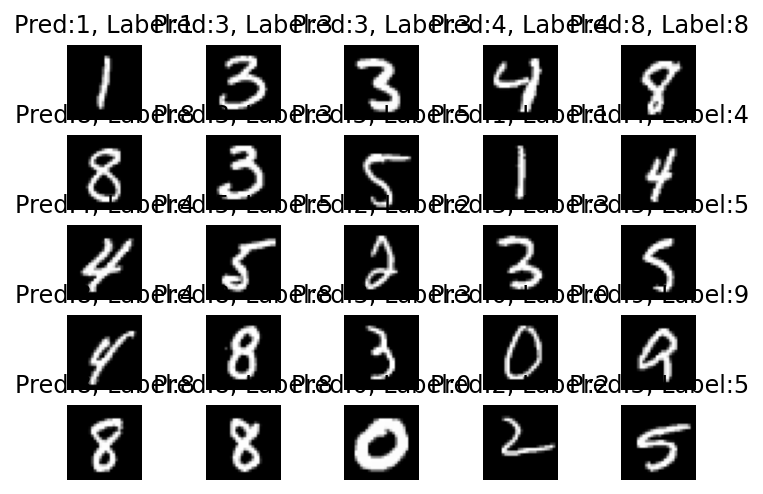

Done


In [90]:
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")